In [2]:
#Import libraries
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from web3 import Web3
from tqdm import tqdm
from dotenv import load_dotenv
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [239]:
# Load .env file
load_dotenv()

# Load API key from .env file
api_key = os.getenv("ALCHEMY_API_KEY")


### Step 1: Set Up Web3 Connection

In [240]:
# Define the Alchemy API endpoint
api_endpoint = f"https://eth-mainnet.g.alchemy.com/v2/{api_key}"

# Set up Web3 connection
w3 = Web3(Web3.HTTPProvider(api_endpoint))

# Check if the connection is successful
if w3.isConnected():
    print("Connected to Ethereum node.")
else:
    print("Connection failed!")

Connected to Ethereum node.


In [241]:
# Define the start and end dates for which the data is required
start_date = datetime(2022, 5, 19)
end_date = datetime(2023, 5, 19)

# Step 2: Estimate the number of blocks per hour and total blocks for the time period

In [242]:
# Alternative to calculate average block time
# Get the number of the latest block
# latest_block_number = w3.eth.get_block('latest')['number']
# # Calculate the block times of the latest 1000 blocks
# block_times = []
# for i in range(1000):
#     # Get the current and previous blocks
#     current_block = w3.eth.get_block(latest_block_number - i)
#     previous_block = w3.eth.get_block(latest_block_number - i - 1)
    
#     # Calculate the block time and append to the list
#     block_time = current_block['timestamp'] - previous_block['timestamp']
#     block_times.append(block_time)

# # Calculate the average block time
# average_block_time = sum(block_times) / len(block_times)
# print(f"Average block time: {average_block_time} seconds")

# Define the block time(in seconds)
avg_block_time = 13  
print(f"Average block time: {avg_block_time} seconds")

# Calculate the estimated number of blocks per hourn(3600 seconds in an hour)
blocks_per_hour = int(3600 / avg_block_time)
print(f"Estimated blocks per hour: {blocks_per_hour}")

# Calculate the total hours for the given time period
total_hours = int((end_date - start_date).total_seconds() / 3600)

# Calculate the total number of blocks for the given time period
total_blocks = total_hours * blocks_per_hour
print(f"Total number of hourly blocks for the given time period: {total_blocks}")

Average block time: 13 seconds
Estimated blocks per hour: 276
Total number of hourly blocks for the given time period: 2417760


### Step 3: Fetch the gas prices and save them in a pandas DataFrame
In this step, we iterate through all the blocks within our determined range, fetch the block details, and extract the gas prices and timestamps. The gas price, initially in hexadecimal format ('baseFeePerGas'), is converted into an integer using `int(block['baseFeePerGas'], 16)`. For each block, a new DataFrame is created to store the gas price and timestamp. We use `pandas.concat()` to combine these new DataFrames with our main `gas_price_data` DataFrame.

The base fee per gas is typically represented as a hexadecimal number in the block information, so it is being converted to an integer using the int() function with base 16.
The gas prices obtained are in "wei", which is the smallest denomination of ether.

For perspective:
1 Ether (ETH) = 1,000,000,000,000,000,000 Wei (1e18 Wei)

In [243]:
# Get the latest block number
latest_block = w3.eth.block_number

In [244]:
# Calculate the start block
start_block = latest_block - total_blocks
start_block

14942400

In [245]:
# Initialize an empty DataFrame to store the gas prices
gas_price_data = pd.DataFrame(columns=['timestamp', 'gas_price'])

# Loop through the blocks, show status bar
for block_number in tqdm(range(start_block, latest_block, blocks_per_hour),
                         desc="Fetching gas prices data"): 
    
    # Get the block details
    block = w3.eth.get_block(block_number)

    # Convert the gas price from hex to integer
    gas_price = int(str(block['baseFeePerGas']), 16)

    # Convert timestamp to datetime and create a DataFrame with the block timestamp and gas price
    block_data = pd.DataFrame({
        'timestamp': [datetime.fromtimestamp(block['timestamp'])],
        'gas_price': [gas_price]
    })

    # Append the block data to the gas price data DataFrame
    gas_price_data = pd.concat([gas_price_data, block_data])

Fetching gas prices data: 100%|██████████| 8760/8760 [40:34<00:00,  3.60it/s]     


In [3]:
gas_price_data = pd.read_csv('resources/gas_price_data_1year.csv')

In [4]:
# Save the DataFrame to a CSV file
gas_price_data.to_csv('resources/gas_price_data.csv', index=False)

In [5]:
gas_price_data.head()

,timestamp,gas_price
0,2022-06-01 11:03:52,63239618198
1,2022-06-01 12:03:48,68281963048
2,2022-06-01 13:08:25,121007946512
3,2022-06-01 14:07:45,126156205023
4,2022-06-01 15:10:50,67510279000


In [6]:
# Set `timestamp` column as index, copy DataFrame
gas_price_df = gas_price_data.set_index('timestamp').copy()

In [7]:
gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2022-06-01 11:03:52 to 2023-05-20 15:50:35
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   gas_price  8760 non-null   int64
dtypes: int64(1)
memory usage: 136.9+ KB


In [8]:
display(gas_price_df.head(40))
gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,67510279000
2022-06-01 16:15:23,32404767035
2022-06-01 17:18:36,31681542751
2022-06-01 18:28:45,63240093401
2022-06-01 19:33:58,41244724759


,gas_price
timestamp,
2023-05-20 07:26:23,36167651916
2023-05-20 08:22:11,42579332023
2023-05-20 09:17:47,36887580795
2023-05-20 10:13:23,42755192159
2023-05-20 11:09:35,34687802687
2023-05-20 12:05:35,29684795277
2023-05-20 13:02:35,31417792342
2023-05-20 13:58:35,31031853696
2023-05-20 14:54:23,28188597658


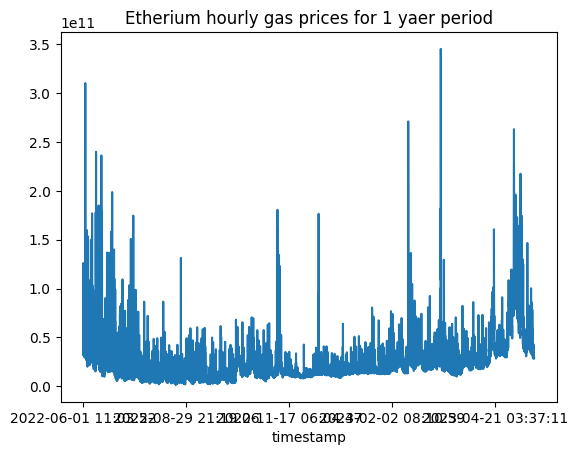

In [9]:
gas_price_df['gas_price'].plot(
    title="Etherium hourly gas prices for 1 yaer period");

### Step 4:Resample to daily data
The format 6.007497e+10 is scientific notation, and it is equivalent to 60,074,970,000. Scientific notation is often used for very large or very small numbers to make them easier to read and write.

In [10]:
gas_price_df.index = pd.to_datetime(gas_price_df.index)

# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = gas_price_df.resample('D').mean()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  354 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [11]:
display(daily_gas_price_df.head(20))
daily_gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01,6.007497e+10
2022-06-02,5.982783e+10
2022-06-03,6.758136e+10
2022-06-04,5.059850e+10
2022-06-05,5.107946e+10
2022-06-06,4.686028e+10
2022-06-07,5.828740e+10
2022-06-08,6.450062e+10
2022-06-09,5.889821e+10


,gas_price
timestamp,
2023-05-11,9.650878e+10
2023-05-12,5.662023e+10
2023-05-13,3.934500e+10
2023-05-14,4.242398e+10
2023-05-15,6.041061e+10
2023-05-16,5.258804e+10
2023-05-17,5.147708e+10
2023-05-18,5.086370e+10
2023-05-19,4.182389e+10


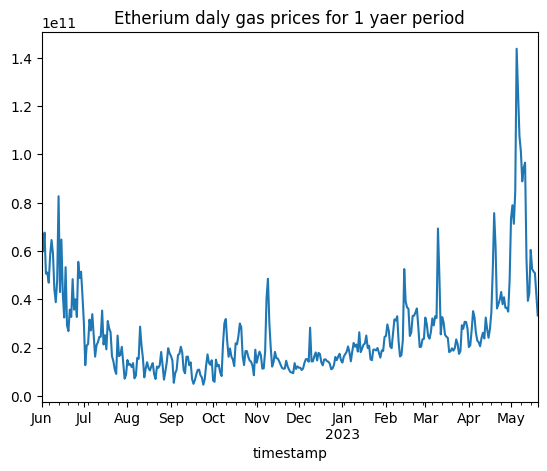

In [12]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

### Step 6: Check for Stationarity
Before applying an ARIMA model, we need to make sure our data is stationary. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
This function will print out the test statistic, p-value, and critical values for the test. If the test statistic is less than the critical value, we can reject the null hypothesis (that the time series is not stationary). If not, we will need to transform the data to make it stationary.

In [13]:
display(daily_gas_price_df.tail(20))
daily_gas_price_df.info()

,gas_price
timestamp,
2023-05-01,7.341860e+10
2023-05-02,7.892379e+10
2023-05-03,7.122593e+10
2023-05-04,8.438872e+10
2023-05-05,1.436768e+11
2023-05-06,1.259894e+11
2023-05-07,1.074979e+11
2023-05-08,1.012665e+11
2023-05-09,8.879350e+10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  354 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [14]:
daily_gas_price_df.head()

,gas_price
timestamp,
2022-06-01,6.007497e+10
2022-06-02,5.982783e+10
2022-06-03,6.758136e+10
2022-06-04,5.059850e+10
2022-06-05,5.107946e+10


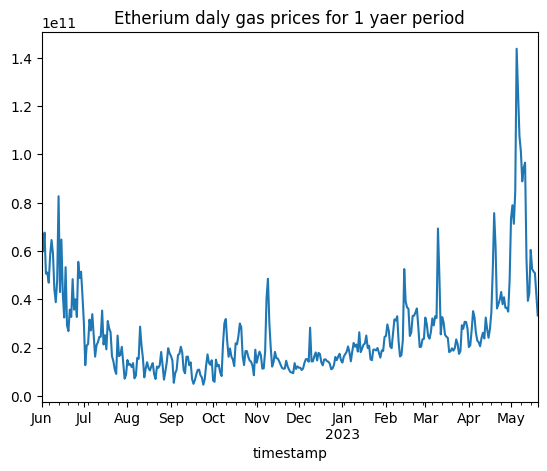

In [15]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

In [16]:
adf_test = adfuller(daily_gas_price_df['gas_price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.012721271931087587


In [17]:
# Define a function to perform the Augmented Dickey-Fuller test
def check_stationarity(data):
    """
    Perform Augmented Dickey-Fuller test to check for stationarity.
    
    Arguments:
    Pandas Series: a series of data to be checked for stationarity.
    
    Returns:
    Prints test statistics and critical values.
    """
    # Perform Augmented Dickey-Fuller test
    # Perform the test using the AIC criterion for choosing the number of lags
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(data, autolag='AIC')  

    # Extract and print the test statistics and critical values
    adf_output = pd.Series(adf_test[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

daily_gas_price_df.to_csv('resources/daily_gas_price_df.csv', index=True)
# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


### Conclusion: 
Looking at your results:
* The Test Statistic (-3.35) is less than the 5% Critical Value (-2.869833).
* The p-value (0.012721) is less than 0.05.

The results allow us to reject the null hypothesis. Therefore, we conclude that the time series is stationary. This means that the statistical properties of the series (like the mean and variance) are not a function of time.

### Step 7: Plot ACF and PACF
The ACF and PACF plots are used to identify the parameters for the ARIMA model. For instance, a sharp drop after lag 'k' in the PACF plot indicates that 'k' should be the order of the AR term. Similarly, a gradual decline in the ACF plot suggests a MA term.
The `plot_acf` function plots the autocorrelation function, which measures the correlation between the time series with a lagged version of itself. The `lags` parameter specifies the number of lags to consider. The `zero` parameter is set to `False` to exclude the correlation of the time series with itself (at lag zero).

Similarly, the `plot_pacf` function plots the partial autocorrelation function. The PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. In other words, it measures the direct effect of the past lagged observations on the current observation.

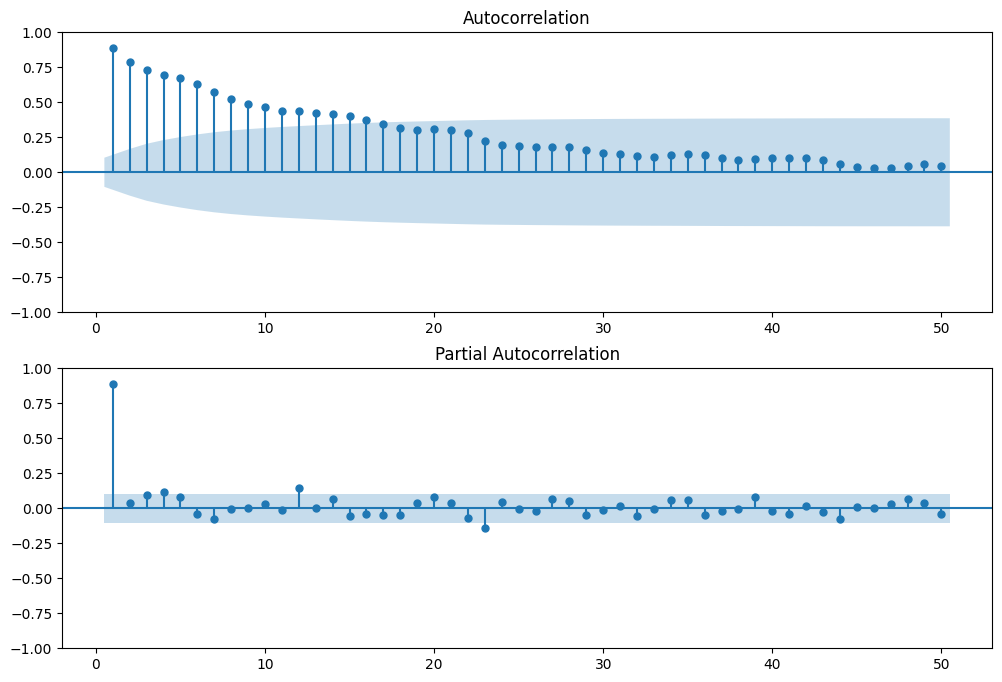

In [18]:
# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

### Further Differencing and Transformation

Based on the results of the Augmented Dickey-Fuller (ADF) test, we can conclude that as the p-value is greater 0.05, and the test statistic is greater than the critical values. Therefore, we do not have enough evidence to reject the null hypothesis of non-stationarity. It suggests that the differenced series may still have some non-stationary components and further differencing or other transformations may be required to achieve stationarity.

In [19]:
# Original :
# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.775592e+00
p-value                        8.686908e-12
#Lags Used                     1.200000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


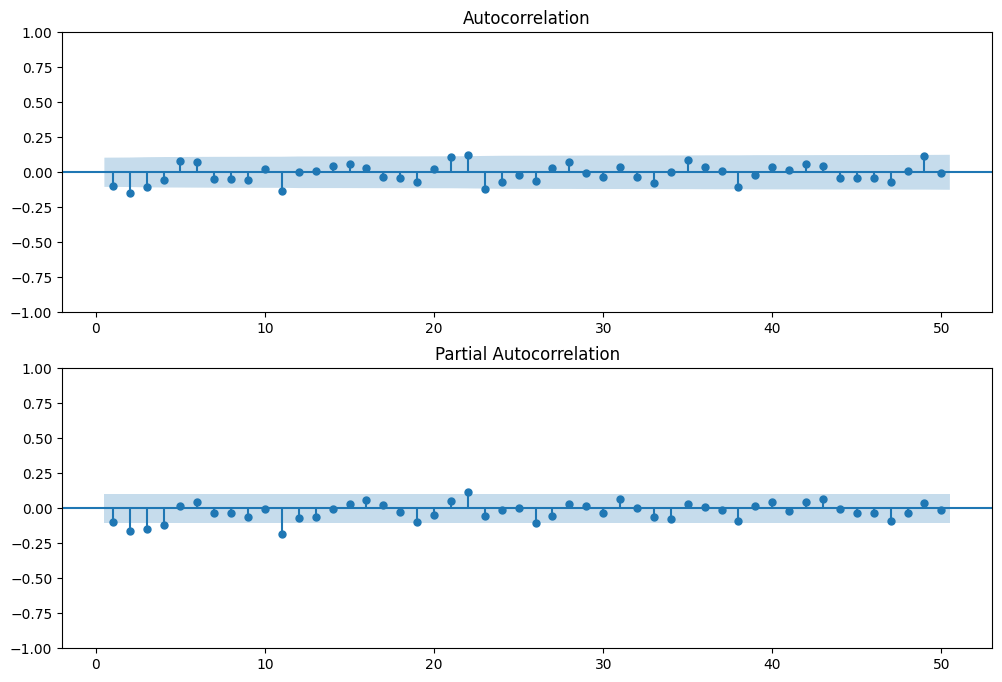

In [20]:
# 1: Technique 1: Simple Differencing
import pandas as pd

# Assuming your time series data is stored in a pandas DataFrame or Series
differenced_data_1 = daily_gas_price_df.diff(1).dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_1['gas_price'])

# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_1['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_1['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.671419e+00
p-value                        1.589916e-11
#Lags Used                     9.000000e+00
Number of Observations Used    3.380000e+02
Critical Value (1%)           -3.449846e+00
Critical Value (5%)           -2.870129e+00
Critical Value (10%)          -2.571346e+00
dtype: float64


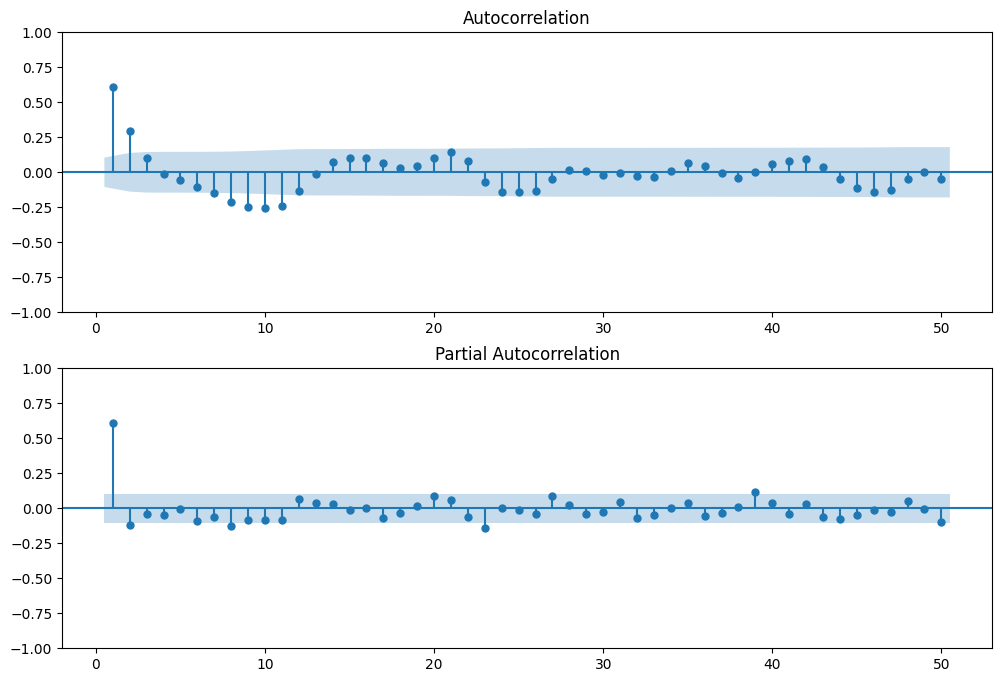

In [21]:
# 2: Rolling Mean Subtraction:
window_size = 7  # Adjust the window size as per your data frequency
rolling_mean = daily_gas_price_df.rolling(window=window_size).mean()
differenced_data_2 = daily_gas_price_df - rolling_mean
differenced_data_2 = differenced_data_2.dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_2['gas_price'])


# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_2['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_2['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -9.990899e+00
p-value                        1.997488e-17
#Lags Used                     1.200000e+01
Number of Observations Used    3.340000e+02
Critical Value (1%)           -3.450081e+00
Critical Value (5%)           -2.870233e+00
Critical Value (10%)          -2.571401e+00
dtype: float64


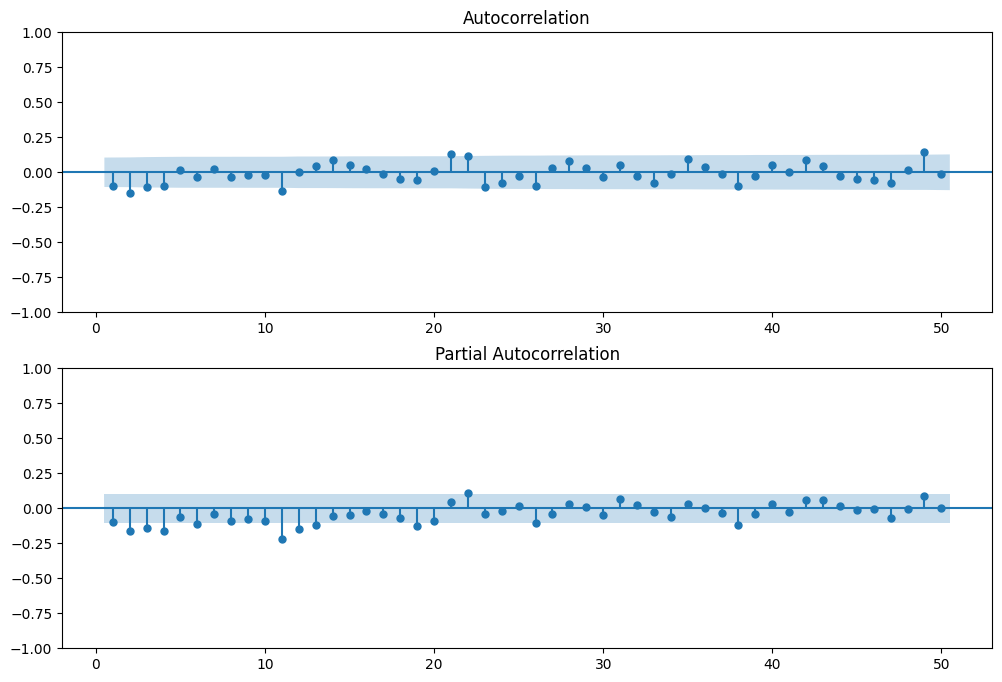

In [22]:
# 3.5 : Rolling Mean Subtraction + Differencing
window_size = 7  # Adjust the window size as per your data frequency
rolling_mean = differenced_data_1.rolling(window=window_size).mean()
differenced_data_3 = differenced_data_1 - rolling_mean
differenced_data_3 = differenced_data_3.dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_3['gas_price'])


# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_3['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_3['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()


After running the above (3) transformations on the original data, we pair them together continuously, to try and find our optimal model. 

# EXTRA - Creating the Arima Model



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [24]:
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


## Using Grid Search and Bayesian Optimization to optimize the ARIMA model

when working with an ARIMA model, we must seperate the different components within our data. Of those components, are the AR component, the Differencing, and the Moving Average (MA). 

 The AR Component is found by looking for spikes in the partial autocorellation plot, or in other words by looking for the 'pin' that visually departs from baseline. In this case, it would be the first value. 
        - p = 1

### Visual Analysis
Based on visual analysis of the plots, it can be understood that in terms of an MA value, there is initially a strong correlation at lag 1, but this corellation continually dimishes, so that by lag 17 all subsequent values lie within the confidence interval. This would mean that as time goes on, there is less an less correlation between the two variables in the data we want to fit to the ARIMA model-- while there may have ben an initial correlation. There is potentially a moving average component, and we assume that starting with a low order MA component (q=2) and re-evaluating the model later will be the best choice. 

---

## Evaluation
To safely conclude which p, d, q pair will result in the optimal outcome, we must utilize objective testing mechanisms to find our optimal model makeup. 

I will try and use the Grid search technique, aswell as the bayesian optimization techniques to optimize the ARIMA model. 

# Grid Search Test:

In [25]:
import itertools
import statsmodels.api as sm
import numpy as np

In [26]:
# Choose which Data to test:
data = differenced_data_1['gas_price']
data_2 = differenced_data_2['gas_price']
data_3 = differenced_data_3['gas_price']
data_4 = daily_gas_price_df['gas_price']

# Convert the data to a dataframe
data = pd.DataFrame(data_2)

# display the first 5 rows of the data
display(data.head())
display(data.info())


,gas_price
timestamp,
2022-06-07,1.957427e+09
2022-06-08,7.538414e+09
2022-06-09,2.068809e+09
2022-06-10,-9.341761e+09
2022-06-11,-1.302202e+10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 2022-06-07 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  348 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


None

<Axes: title={'center': 'Daily Gas Prices - Data For Arima Model'}, xlabel='timestamp'>

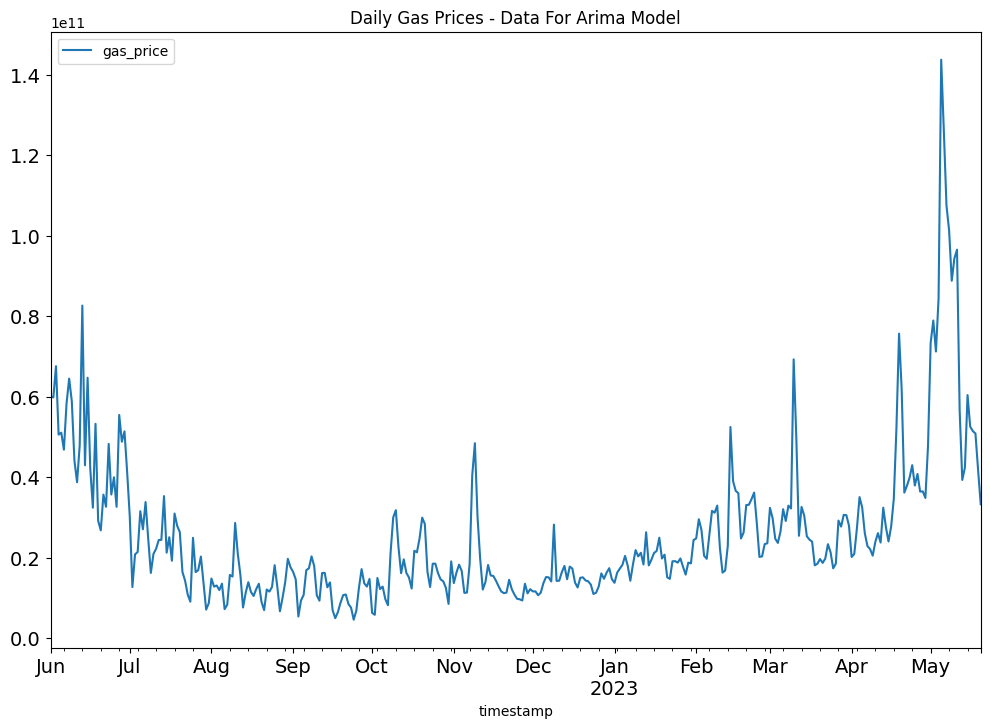

In [27]:
# show a plot of the data
daily_gas_price_df.plot(figsize=(12,8), title='Daily Gas Prices - Data For Arima Model', fontsize=14)

In [28]:
best_mse = float('inf')  # Initialize the best performance metrics
best_mae = float('inf')
best_rmse = float('inf')
best_aic = float('inf')

In [29]:

best_mse_model = None  # Initialize the best model variables
best_mae_model = None
best_rmse_model = None
best_aic_model = None



In [30]:
# Determine the index at which to split the data
split_index = int(len(data_3) * 0.8)  # Split at 80% of the data

# Split the data into train and test sets
train = data_3.iloc[:split_index]
test = data_3.iloc[split_index:]

In [31]:
# Define the ranges for p, d, and q values
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

In [32]:
data = data_3

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Choose the number of times to iterate over all p, d, and q values
num_tries = 10

# Iterate over all combinations of p, d, and q values, 50 times

for _ in range(num_tries):
    for p, d, q in itertools.product(p_values, d_values, q_values):
        
            # Fit ARIMA model with current combination of p, d, and q
            model = sm.tsa.ARIMA(train, order=(p, d, q))
            fitted_model = model.fit()

            # Calculate AIC
            aic = fitted_model.aic

            # Make predictions on the testing set
            predictions = fitted_model.predict(start=test.index[0], end=test.index[-1])

            # Evaluate the model's performance
            mse = mean_squared_error(test, predictions)
            mae = mean_absolute_error(test, predictions)
            rmse = np.sqrt(mse)

            if mse < best_mse:
                best_mse = mse
                best_mse_model = fitted_model
                best_mse_predictions = predictions

            if mae < best_mae:
                best_mae = mae
                best_mae_model = fitted_model
                best_mae_predictions = predictions
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_rmse_model = fitted_model
                best_rmse_predictions = predictions
            
            # Check if current model has lower AIC than the previous best model
            if aic < best_aic:
                best_aic = aic
                best_aic_model = fitted_model
                best_aic_predictions = predictions
                

# After the loop, you can access the best_model and best_aic variables
# which hold the results of the best-performing model across multiple tries

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

In [34]:
display(print("Root Mean Squared Error (RMSE):", best_rmse))
display(print(f"Best model: {best_rmse_model.summary()}"))

Root Mean Squared Error (RMSE): 11073260063.14754


None

Best model:                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  277
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -6617.206
Date:                Wed, 31 May 2023   AIC                          13250.413
Time:                        14:03:43   BIC                          13279.405
Sample:                    06-08-2022   HQIC                         13262.046
                         - 03-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.277e+07   1.88e-10   1.74e+17      0.000    3.28e+07    3.28e+07
ar.L1          1.5787      0.047     33.815      0.000       1.487       1.670
ar.L2         -1.4070      0.060    -23.

None

In [35]:
data.head()

timestamp
2022-06-08    5.580987e+09
2022-06-09   -5.469605e+09
2022-06-10   -1.141057e+10
2022-06-11   -3.680261e+09
2022-06-12    9.611930e+09
Freq: D, Name: gas_price, dtype: float64

### Actual vs. Predicted Values:

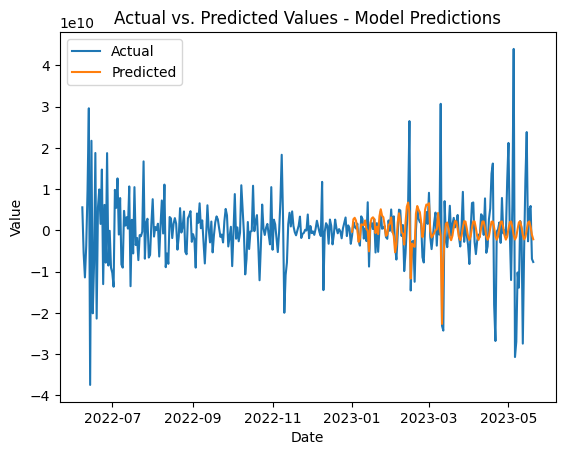

The correlation between the original data and the predictions is: 0.39273373942002243


None

In [36]:
import matplotlib.pyplot as plt
start_date = '2023-01-01'
end_date = '2023-05-20'
# Plot actual values
plt.plot(data.index, data, label='Actual')
# Plot predicted values from the best model
predicted_values = best_rmse_model.predict(start=start_date, end=end_date)
plt.plot(predicted_values.index, predicted_values, label='Predicted')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values - Model Predictions')
# Add legend
plt.legend()
# Show the plot
plt.show()
# Display the correlation between the original data and the predicted values
display(print("The correlation between the original data and the predictions is:",data.corr(predicted_values)))

In [37]:
test = pd.DataFrame(test)
train = pd.DataFrame(train)
display(test.head())
display(train.head())

,gas_price
timestamp,
2023-03-12,-2.429288e+10
2023-03-13,7.080372e+09
2023-03-14,-2.324215e+09
2023-03-15,-4.073376e+09
2023-03-16,2.878785e+08


,gas_price
timestamp,
2022-06-08,5.580987e+09
2022-06-09,-5.469605e+09
2022-06-10,-1.141057e+10
2022-06-11,-3.680261e+09
2022-06-12,9.611930e+09


# Actual vs. Predicted Values - Rolling:

In [90]:
data = pd.DataFrame(data)
# Review the data
display(data.info())
# Display the first 5 rows of the data
display(data.head())
display(data.describe())
display(data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2022-06-08 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  347 non-null    float64
dtypes: float64(1)
memory usage: 13.5 KB


None

,gas_price
timestamp,
2022-06-08,5.580987e+09
2022-06-09,-5.469605e+09
2022-06-10,-1.141057e+10
2022-06-11,-3.680261e+09
2022-06-12,9.611930e+09


,gas_price
count,3.470000e+02
mean,-4.674380e+07
std,8.239468e+09
min,-3.746558e+10
25%,-2.915230e+09
50%,2.371777e+08
75%,2.942039e+09
max,4.397740e+10


,gas_price
timestamp,
2023-05-16,-2.650362e+09
2023-05-17,5.014737e+09
2023-05-18,5.907342e+09
2023-05-19,-6.926046e+09
2023-05-20,-7.667660e+09


<Axes: title={'center': 'Daily Gas Prices - Data For Arima Model'}, xlabel='timestamp'>

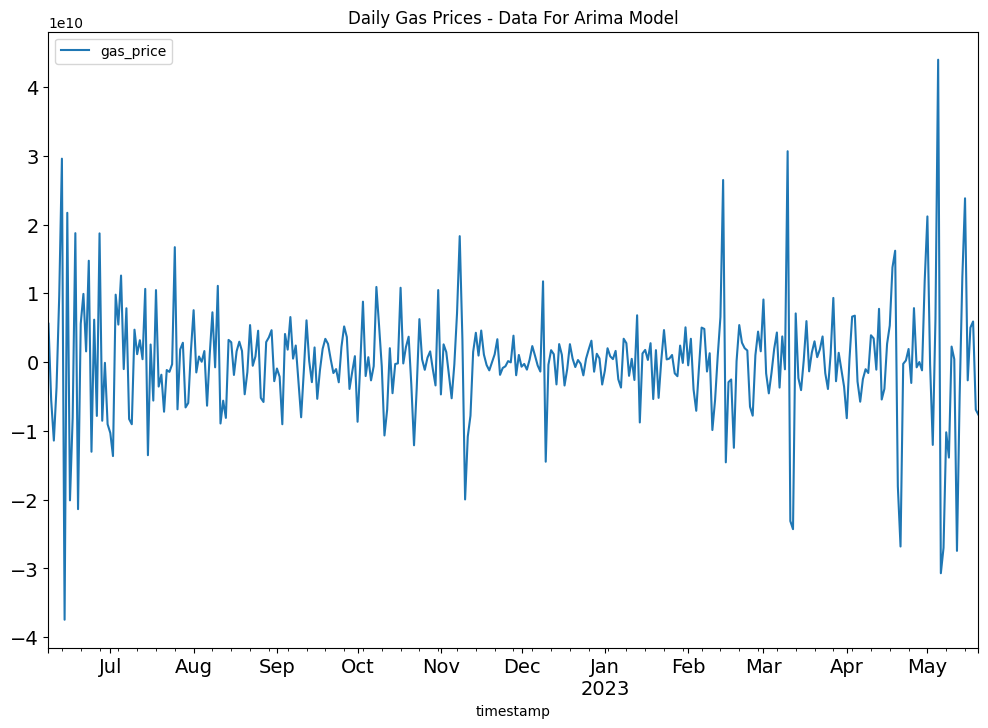

In [89]:
data.plot(figsize=(12,8), title='Daily Gas Prices - Data For Arima Model', fontsize=14)

In [87]:
# Define a function for the rolling forecast using ARIMA model
def arima_rolling_forecast(train, order, window_size=7):
    """
    Perform a rolling forecast using an ARIMA model with specified window size.
    Parameters:
    train (array-like): The training data.
    order (tuple): The order of the ARIMA model.
    window_size (int): The size of the rolling window.
    Returns:
    predictions (list): The forecasts for the test data.
    """
    predictions = []
    for i in range(0, len(train) - window_size):
        # Fit the ARIMA model on a window of data and make a one-step forecast
        window_data = train[i: i + window_size]
        yhat = best_rmse_model.forecast()[0]
        # Add the forecast to the list of predictions
        predictions.append(yhat)
    return predictions

### 1: OG Data

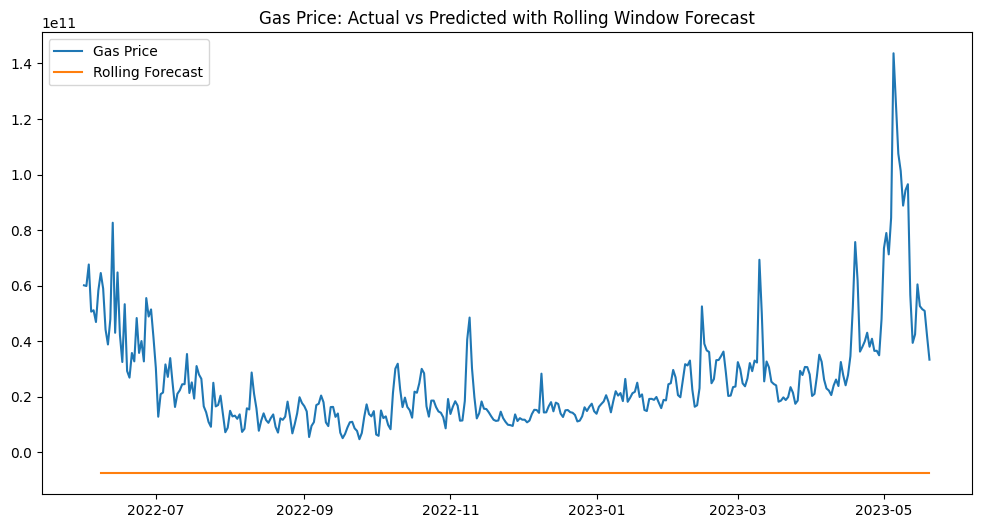

AttributeError: 'float' object has no attribute 'shape'

In [88]:
# Set the best order from the previous step
order = (2, 2, 0)
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(daily_gas_price_df['gas_price'].values, order, window_size=7)
# Add the rolling forecast to the DataFrame
daily_gas_price_df['rolling_forecast'] = None
daily_gas_price_df.loc[daily_gas_price_df.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

# Then plot it
plt.figure(figsize=(12,6))
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Gas Price')
plt.plot(daily_gas_price_df.index, daily_gas_price_df['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()
# Display the correlation between the original data and the predicted values
display(print("The correlation between the original data and the predictions is:",daily_gas_price_df['gas_price'].corr(daily_gas_price_df['rolling_forecast'])))

#### 2: Differenced Data:

/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/sit

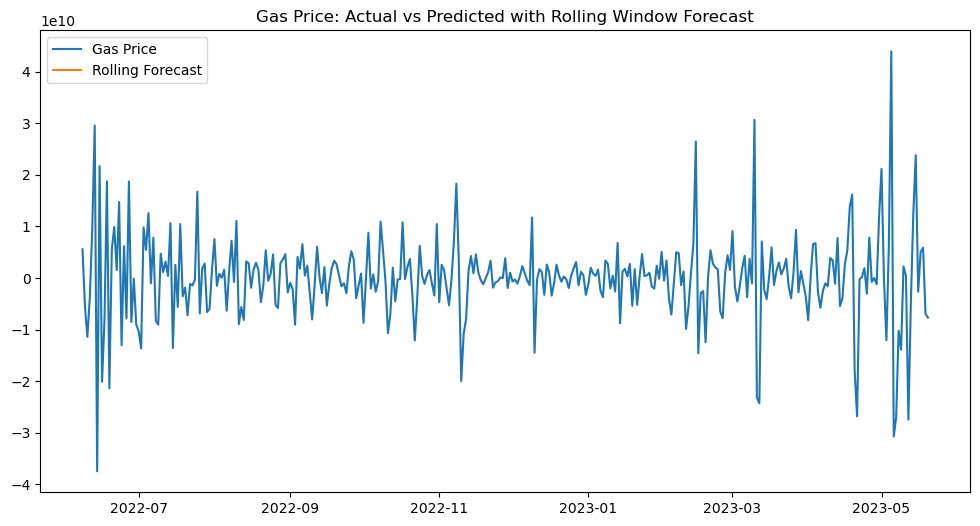

In [ ]:
# Set the best order from the previous step
order = (3, 0, 3)
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(data['gas_price'].values, order, window_size=7)
rolling_forecast = best_rmse_predictions
# Add the rolling forecast to the DataFrame
data['rolling_forecast'] = None
data.loc[data.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

# Then plot it
plt.figure(figsize=(12,6))
plt.plot(data.index, data['gas_price'], label='Gas Price')
plt.plot(data.index, data['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()

In [83]:
display(train)
display(test)

,gas_price
timestamp,
2022-06-08,5.580987e+09
2022-06-09,-5.469605e+09
2022-06-10,-1.141057e+10
2022-06-11,-3.680261e+09
2022-06-12,9.611930e+09
...,...
2023-03-07,-3.707020e+09
2023-03-08,3.734404e+09
2023-03-09,-1.047435e+09


,gas_price
timestamp,
2023-03-12,-2.429288e+10
2023-03-13,7.080372e+09
2023-03-14,-2.324215e+09
2023-03-15,-4.073376e+09
2023-03-16,2.878785e+08
...,...
2023-05-16,-2.650362e+09
2023-05-17,5.014737e+09
2023-05-18,5.907342e+09


In [84]:
# Define a function for the rolling forecast using ARIMA model
def arima_rolling_forecast(train, order, window_size=7):
    """
    Perform a rolling forecast using an ARIMA model with specified window size.
    Parameters:
    train (array-like): The training data.
    order (tuple): The order of the ARIMA model.
    window_size (int): The size of the rolling window.
    Returns:
    predictions (list): The forecasts for the test data.
    """
    predictions = []
    for i in range(0, len(train) - window_size):
        # Fit the ARIMA model on a window of data and make a one-step forecast
        window_data = train[i: i + window_size]
        yhat = best_rmse_model.forecast()[0]
        # Add the forecast to the list of predictions
        predictions.append(yhat)
    return predictions

In [85]:
display(best_rmse_predictions)

2023-03-12   -7.642570e+09
2023-03-13   -1.268161e+09
2023-03-14    1.635755e+09
2023-03-15    1.887267e+09
2023-03-16    2.801608e+08
                  ...     
2023-05-16    1.889778e+09
2023-05-17    2.161257e+09
2023-05-18    8.440241e+08
2023-05-19   -1.074894e+09
2023-05-20   -2.162242e+09
Freq: D, Name: predicted_mean, Length: 70, dtype: float64

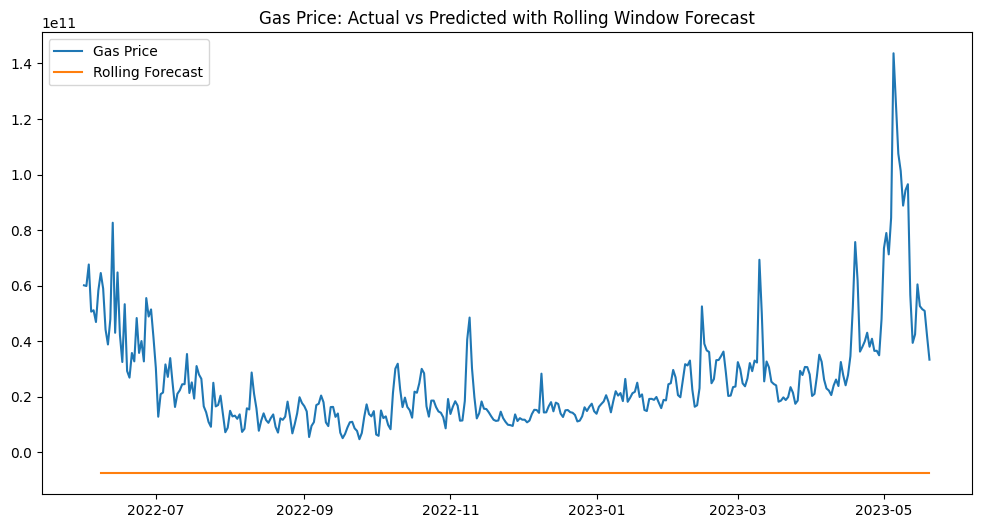

In [86]:
# Set the best order from the previous step
order = (0, 2, 2)
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(daily_gas_price_df['gas_price'].values, order, window_size=7)
# Add the rolling forecast to the DataFrame
daily_gas_price_df['rolling_forecast'] = None
daily_gas_price_df.loc[daily_gas_price_df.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

# Then plot it
plt.figure(figsize=(12,6))
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Gas Price')
plt.plot(daily_gas_price_df.index, daily_gas_price_df['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()

In [ ]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    Returns:
    mape (float): The MAPE.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Slice test['gas_price'].values and rolling_forecast to have the same size
size = min(len(test['gas_price'].values), len(rolling_forecast))
# Calculate MAPE for the rolling forecast
mape = mean_absolute_percentage_error(test['gas_price'].values[:size], rolling_forecast[:size])
print('The Mean Absolute Percentage Error for the rolling forecast is: ', mape)

The Mean Absolute Percentage Error for the rolling forecast is:  6038.840070303625


In [48]:
# display whether 'data' is a series or a dataframe
display(type(data))
# turn data into a time series
data.index = pd.to_datetime(data.index)
# display whether 'data' is a series or a dataframe
display(type(data))
display(data)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

,gas_price
timestamp,
2022-06-08,5.580987e+09
2022-06-09,-5.469605e+09
2022-06-10,-1.141057e+10
2022-06-11,-3.680261e+09
2022-06-12,9.611930e+09
...,...
2023-05-16,-2.650362e+09
2023-05-17,5.014737e+09
2023-05-18,5.907342e+09


In [54]:
test = pd.DataFrame(test)
train = pd.DataFrame(train)

# New start:

In [55]:
display(data.head)
display(data.tail())

<bound method NDFrame.head of                gas_price
timestamp               
2022-06-08  5.580987e+09
2022-06-09 -5.469605e+09
2022-06-10 -1.141057e+10
2022-06-11 -3.680261e+09
2022-06-12  9.611930e+09
...                  ...
2023-05-16 -2.650362e+09
2023-05-17  5.014737e+09
2023-05-18  5.907342e+09
2023-05-19 -6.926046e+09
2023-05-20 -7.667660e+09

[347 rows x 1 columns]>

,gas_price
timestamp,
2023-05-16,-2.650362e+09
2023-05-17,5.014737e+09
2023-05-18,5.907342e+09
2023-05-19,-6.926046e+09
2023-05-20,-7.667660e+09


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Choose the number of times to iterate over all p, d, and q values
num_tries = 10

# Iterate over all combinations of p, d, and q values, 50 times

for _ in range(num_tries):
    for p, d, q in itertools.product(p_values, d_values, q_values):
        
            # Fit ARIMA model with current combination of p, d, and q
            model = sm.tsa.ARIMA(train, order=(p, d, q))
            fitted_model = model.fit()

            # Calculate AIC
            aic = fitted_model.aic

            # Make predictions on the testing set
            predictions = fitted_model.predict(start=test.index[0], end=test.index[-1])

            # Evaluate the model's performance
            mse = mean_squared_error(test, predictions)
            mae = mean_absolute_error(test, predictions)
            rmse = np.sqrt(mse)

            if mse < best_mse:
                best_mse = mse
                best_mse_model = fitted_model
                best_mse_predictions = predictions

            if mae < best_mae:
                best_mae = mae
                best_mae_model = fitted_model
                best_mae_predictions = predictions
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_rmse_model = fitted_model
                best_rmse_predictions = predictions
            
            # Check if current model has lower AIC than the previous best model
            if aic < best_aic:
                best_aic = aic
                best_aic_model = fitted_model
                best_aic_predictions = predictions
                

# After the loop, you can access the best_model and best_aic variables
# which hold the results of the best-performing model across multiple tries

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

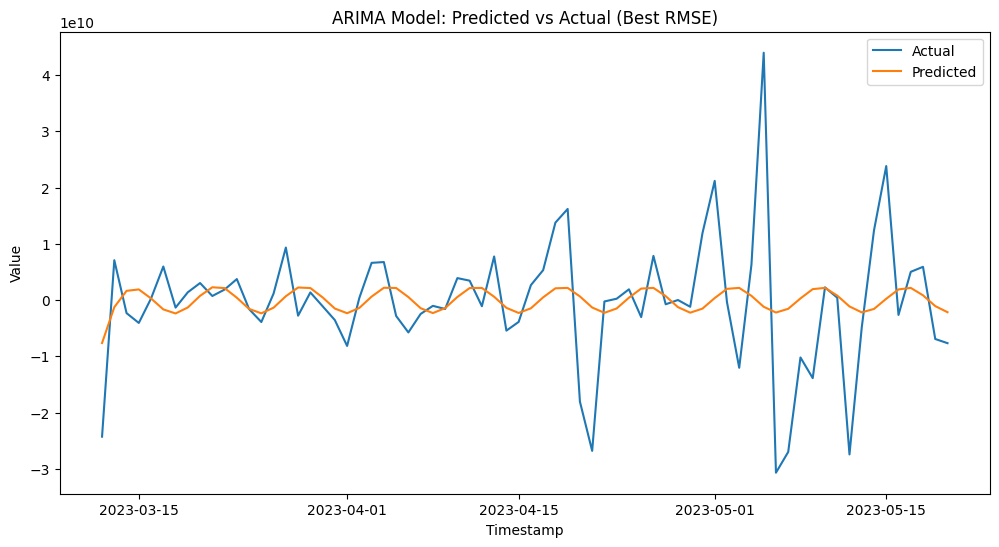

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, best_rmse_predictions, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('ARIMA Model: Predicted vs Actual (Best RMSE)')
plt.legend()
plt.show()

In [74]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def rolling_forecast(p,d,q, data, forecast_steps):
    """
    Perform a rolling forecast using an ARIMA model.

    Parameters:
    - arima_model: Initialized ARIMA model from statsmodels.tsa.arima.model.ARIMA.
    - data: Time series data used for forecasting.
    - forecast_steps: Number of future steps to forecast.

    Returns:
    - forecasts: Array of forecasted values.
    """
    arima_model = ARIMA(data, order=(p, d, q))

    # Copy the original data to avoid modifying it
    data_copy = data.copy().values

    # Initialize an empty array to store the forecasted values
    forecasts = np.empty(forecast_steps)

    # Perform the rolling forecast
    for i in range(forecast_steps):
        # Fit the ARIMA model to the current data
        arima_model_fit = arima_model.fit(data_copy)

        # Forecast the next value
        forecast = arima_model_fit.forecast(steps=1)

        # Store the forecasted value
        forecasts[i] = forecast[0]

        # Append the forecasted value to the data for the next iteration
        data_copy = np.append(data_copy, forecast)

    return forecasts


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              gas_price   No. Observations:                  277
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -6617.206
Date:                Wed, 31 May 2023   AIC                          13250.413
Time:                        15:31:22   BIC                          13279.405
Sample:                    06-08-2022   HQIC                         13262.046
                         - 03-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.277e+07   1.88e-10   1.74e+17      0.000    3.28e+07    3.28e+07
ar.L1          1.5787      0.047     33.815      0.000       1.487       1.670
ar.L2         -1.4070      0.060    -23.415      0.000      -1.525      -1.289
ar.L3          0.3266      0.048      6.808      0.000       0.233       0.421
ma.L1         -2.2028      0.023    -94.556      0.000      -2.248      -2.157
ma.L2          2.1835      0.045     48.093      0.000       2.095       2.272
ma.L3         -0.9674      0.028    -34.510      0.000      -1.022      -0.912
sigma2      3.009e+19   1.22e-21   2.47e+40      0.000    3.01e+19    3.01e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               701.09
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+55. Standard errors may be unstable.
"""

best rmse: 11073260063.14754


Text(0.5, 1.0, 'ARIMA Model: Predicted vs Actual (Best RMSE)')

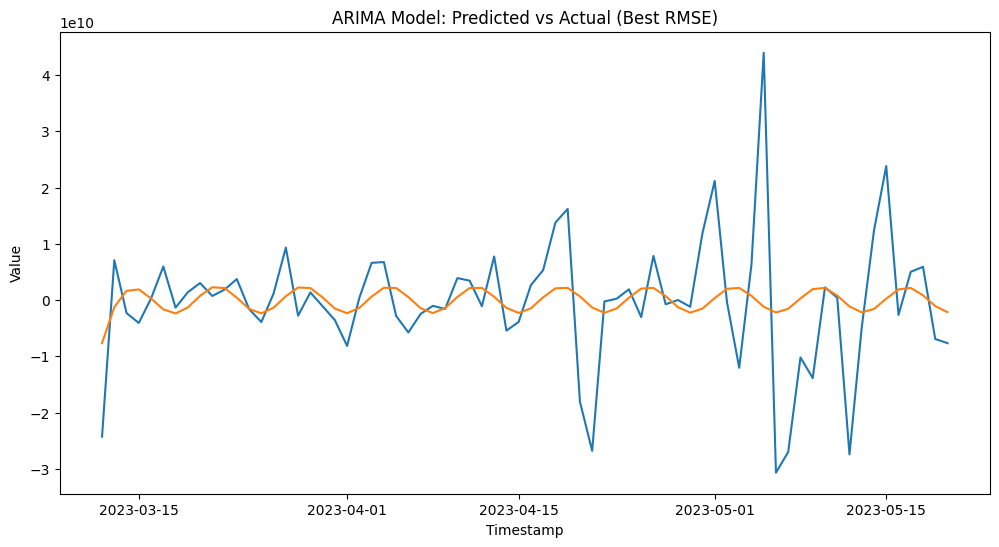

In [123]:
# Display the best performing model with the best rmse
display(best_rmse_model.summary())
# Generate predictions from the model we just fit
best_rmse_predictions = best_rmse_model.predict(start=test.index[0], end=test.index[-1])
# Convert those predictions and the actual performance to a dataframe
results_df = pd.DataFrame({'Prediction': predictions, 'ACtual': best_rmse_predictions})
print(f"best rmse: {best_rmse}")
# plot the best rmse predictions 
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, best_rmse_predictions, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('ARIMA Model: Predicted vs Actual (Best RMSE)')



In [116]:
# Assuming you have already initialized an ARIMA model, arima_model

# Assuming you have your time series data stored in a pandas Series, data


# Set the p, d, q values for the ARIMA model
p = 3
d = 0
q = 3

# Set the number of future steps to forecast
forecast_steps = 10

# Perform the rolling forecast
forecasts = rolling_forecast(p,d,q, data, forecast_steps)

# Print the forecasted values
print(forecasts)

TypeError: 'list' object is not callable

In [64]:
import numpy as np

def rolling_forecast(fitted_model, data, forecast_steps):
    """
    Perform a rolling forecast using a fitted ARIMA model.

    Parameters:
    - fitted_model: Fitted ARIMA model from statsmodels.tsa.arima.model.ARIMAResults.
    - data: Time series data used for forecasting.
    - forecast_steps: Number of future steps to forecast.

    Returns:
    - forecasts: Array of forecasted values.
    """

    # Copy the original data to avoid modifying it
    data_copy = data.copy()

    # Initialize an empty array to store the forecasted values
    forecasts = np.empty(forecast_steps)

    # Perform the rolling forecast
    for i in range(forecast_steps):
        # Forecast the next value using the fitted model
        forecast = fitted_model.forecast(steps=1)

        # Store the forecasted value
        forecasts[i] = forecast[0]

        # Append the forecasted value to the data for the next iteration
        data_copy = np.append(data_copy, forecast[0])

    return forecasts

In [91]:
# Create a function that forecasts the next 3 months of gas prices
def forecast_gas_prices(fitted_model, data):
    """
    Forecast the next 3 months of gas prices using a fitted ARIMA model.

    Parameters:
    - fitted_model: Fitted ARIMA model from statsmodels.tsa.arima.model.ARIMAResults.
    - data: Time series data used for forecasting.

    Returns:
    - forecasts: Array of forecasted values.
    """
    # Forecast the next 3 months
    forecasts = rolling_forecast(fitted_model, data, forecast_steps=3)

    # Return the forecasts
    return forecasts

In [102]:
p = 3 
d = 0
q = 3

# Create the train and test data with an 80% split
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]
display(test)
test.index = pd.to_datetime(test.index)


,gas_price
timestamp,
2023-03-12,-2.429288e+10
2023-03-13,7.080372e+09
2023-03-14,-2.324215e+09
2023-03-15,-4.073376e+09
2023-03-16,2.878785e+08
...,...
2023-05-16,-2.650362e+09
2023-05-17,5.014737e+09
2023-05-18,5.907342e+09


/var/folders/16/yz1fchh96gng2f360h77lh4w0000gn/T/ipykernel_76583/3331732181.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('resources/gas_price_data_1year.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


predicted=16452438527.641031, expected=14151536343
predicted=16128132539.19814, expected=14205318725
predicted=15980734742.852581, expected=13823611994
predicted=15799698919.616854, expected=12321254751
predicted=15098490373.714733, expected=13569356294
predicted=15339353836.404219, expected=12377934878
predicted=14920531861.942146, expected=14113042907
predicted=15448267819.340254, expected=15539435241
predicted=16167381237.565926, expected=12479828753
predicted=15245151527.229744, expected=16481486410
predicted=16423584383.143642, expected=16282196937
predicted=16811604324.624006, expected=20478035962
predicted=18540163590.291832, expected=22941148446
predicted=20194300975.19866, expected=27636684364
predicted=22592676977.228954, expected=22093650549
predicted=21397083684.33984, expected=24597908165
predicted=21870675938.13697, expected=29579963397
predicted=24092968353.33601, expected=20033553624
predicted=21139858735.760853, expected=42339563686
predicted=28819671104.158485, expect

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=31028596030.21058, expected=31348589881
predicted=31335215336.437065, expected=29070897980
predicted=31156279423.31386, expected=27523571265
predicted=29764908939.306393, expected=23548540617
predicted=28304582998.875755, expected=22121348106
predicted=26519215704.13951, expected=26308046960
predicted=28289363918.153656, expected=26498414103
predicted=28281610302.24629, expected=36016341795
predicted=32855782381.801292, expected=43553038057
predicted=36895728759.706635, expected=136520597729
predicted=77571310172.52904, expected=51409764772
predicted=55569837397.62526, expected=48539925823
predicted=47342346043.45033, expected=36011689425
predicted=39322973968.85594, expected=36382581548
predicted=36944369633.534935, expected=44986558473
predicted=39610845581.24513, expected=38707320050
predicted=38069815942.86302, expected=57346228411
predicted=45139231860.29816, expected=33248682893
predicted=37778475010.45962, expected=30362994725
predicted=33882515838.03381, expected=2473

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=57185413524.05082, expected=59968974911
predicted=55668542719.23204, expected=61585752576
predicted=56545325379.73928, expected=50837807072
predicted=51419903773.20608, expected=69218407897
predicted=58654509897.73552, expected=57879838257
predicted=55421612894.11171, expected=75335469685
predicted=60139969876.902695, expected=61392810964
predicted=56423004349.63471, expected=55543703928
predicted=52047370220.78845, expected=47329136707
predicted=47442614947.974045, expected=49776293941
predicted=46125983166.28291, expected=47954178448
predicted=44602032887.42706, expected=63394692210
predicted=51251824115.88873, expected=61057111677
predicted=52171061631.414856, expected=80148181972
predicted=61958350632.62834, expected=160748831469
predicted=104546912775.9375, expected=123838287642
predicted=100302052719.66847, expected=100006824744
predicted=91080681758.43437, expected=65882592434
predicted=73849468734.64868, expected=58096422982


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=61109124200.12068, expected=57457382867
predicted=58143658913.42835, expected=70312998202
predicted=62584983051.602356, expected=72133273286
predicted=61732220035.51398, expected=49285225111
predicted=51098960447.10393, expected=64008462750


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=59572439495.13486, expected=42316276646
predicted=50423542042.41395, expected=43490558600
predicted=48446021721.935455, expected=39870351272
predicted=45713629185.81023, expected=36560526638


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=43669509046.66634, expected=39368239667
predicted=43792301957.19165, expected=32598446073
predicted=41081795586.04758, expected=39413637570
predicted=35283117547.05522, expected=44531424302
predicted=38315573233.17001, expected=41416266403
predicted=37526590541.78542, expected=35745773652
predicted=35077034094.56697, expected=38903679996
predicted=35856141307.90303, expected=37545820822
predicted=35159229365.228065, expected=31446999281
predicted=31936181477.309124, expected=36738332339
predicted=33607009152.409615, expected=36305921738
predicted=33585480010.61905, expected=43423062697
predicted=36948682971.04586, expected=37466408140
predicted=35338877417.1218, expected=39897881690
predicted=36102222550.65985, expected=36123406533
predicted=34709895235.686905, expected=35948735359
predicted=33959533630.85015, expected=38282722222
predicted=34971730602.905235, expected=42780651214
predicted=37217789883.61663, expected=32175323056
predicted=32880164842.269302, expected=3513173

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=52451600849.248566, expected=52277176060
predicted=50221049629.97771, expected=44700889039
predicted=46174509854.24765, expected=37077481032
predicted=41310779847.603294, expected=39001862889
predicted=40705518374.52953, expected=45397765872
predicted=43291350657.84656, expected=34628623552
predicted=39369595486.29747, expected=45954411922
predicted=43105069231.329666, expected=35501576346
predicted=39733459193.328606, expected=30963344832
predicted=36279643125.6022, expected=32762039678
predicted=36053562753.52965, expected=37879983234
predicted=38280956425.62523, expected=35820439686
predicted=38193287674.13185, expected=36245752168
predicted=38107932647.19399, expected=34978507900
predicted=37758502859.85421, expected=32845132456
predicted=36422475816.34966, expected=31345143124
predicted=35485535265.51718, expected=32970962991
predicted=35686050783.7134, expected=33976649595
predicted=36352933388.90345, expected=36089660174
predicted=37265807291.62764, expected=5856956571

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=40912296862.9763, expected=37447133259
predicted=39658544265.87546, expected=35703937844
predicted=37931585003.608475, expected=34696935781
predicted=37388379441.16088, expected=41295147941
predicted=39690416589.59715, expected=35864975855
predicted=38468357960.58997, expected=31851608648
predicted=35738180325.46384, expected=37022463571
predicted=37658336183.07047, expected=33884173537


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=36265890938.69864, expected=31753375444
predicted=35433713231.85147, expected=32316562111
predicted=34883261133.10741, expected=34031664374
predicted=35918073483.09145, expected=34995524239
predicted=36203244486.36431, expected=34443493060
predicted=36489826797.572334, expected=35375090678
predicted=36515858873.72628, expected=33888402139
predicted=36302769603.69892, expected=33875359688
predicted=35734737818.38747, expected=32797758138
predicted=35512257169.35011, expected=34111292841
predicted=35540486481.82941, expected=57871206719
predicted=46736410560.859314, expected=38336805020
predicted=41157115599.10082, expected=38909377028
predicted=39960483908.68146, expected=33864527659
predicted=36954855286.370964, expected=36627997387
predicted=37551480280.429214, expected=43527091848
predicted=40512827378.924545, expected=31593806753
predicted=36430932083.85149, expected=42519496163
predicted=39661793413.428635, expected=38360318092
predicted=39223306396.866875, expected=34582

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=36867008168.09476, expected=31970165150
predicted=35437844001.01312, expected=31944343776
predicted=34504587333.822334, expected=37838242652


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=37087106813.85829, expected=40236818681
predicted=38809329895.04993, expected=35103511901
predicted=37390708393.93483, expected=37997586779
predicted=37815827077.48133, expected=30535826740
predicted=34993751518.326805, expected=32840493434
predicted=34664736594.384125, expected=33912552202
predicted=35457542237.21501, expected=32337842002
predicted=34547893823.02571, expected=31652006779
predicted=34350928557.068554, expected=36446350751
predicted=35993847889.572716, expected=34785479858
predicted=36210862408.93266, expected=34374341119
predicted=35631909384.34758, expected=42766630440
predicted=39656720882.484474, expected=47946625537
predicted=42897093336.65892, expected=33828424383
predicted=37973188014.9217, expected=42423592617
predicted=39844321984.83119, expected=34738399596
predicted=37454485631.53137, expected=44790001333
predicted=40714554835.76106, expected=34678330757
predicted=37743099109.15553, expected=38327561622
predicted=37865203454.89548, expected=38617188

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=36529336426.90204, expected=33102983776
predicted=34889750367.40733, expected=34666024875
predicted=35740708275.97344, expected=33053763797
predicted=34643669483.73903, expected=33906439576
predicted=35248897770.6378, expected=33715642287
predicted=34770458940.31444, expected=38550972784
predicted=37351031083.0347, expected=39056937582
predicted=37841164492.55963, expected=42836025981
predicted=40286673785.997284, expected=41327432618
predicted=39841281608.571655, expected=44297654735
predicted=41600996251.7754, expected=34028951142
predicted=37009654031.65433, expected=31166812622
predicted=34744955340.24869, expected=35020926169
predicted=35216033818.60487, expected=35372820819
predicted=36040127054.986404, expected=31417189096
predicted=33986193805.185715, expected=29728593237
predicted=33053848702.59182, expected=30873055891
predicted=32725316759.148956, expected=29660423889
predicted=32566070931.36202, expected=33540897166
predicted=33722577613.851067, expected=334016862

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=51115511618.32904, expected=48964423709
predicted=51271690685.99804, expected=58186674061
predicted=53704109981.852875, expected=41129049930
predicted=48148181779.03264, expected=40623152530
predicted=44054678183.881714, expected=54390860240
predicted=51561159297.19144, expected=44276254990


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=46545799507.4312, expected=37112587561
predicted=43880264554.74843, expected=35766969269
predicted=39894210094.1725, expected=30679909497
predicted=38499630593.99692, expected=46278612261
predicted=43507692383.515526, expected=40080210201
predicted=44010628780.50125, expected=38971890941


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=41164246664.156715, expected=38365405913


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=42409778884.254456, expected=37991821618
predicted=40083645665.9032, expected=37279809754


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=41466465724.8344, expected=41075904257
predicted=41480902718.25561, expected=34634655634
predicted=40322701784.66339, expected=51625940644
predicted=46166431734.15367, expected=40501801300
predicted=44673599955.49903, expected=38085751602
predicted=40455528551.654785, expected=44489136579


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=44816405784.588486, expected=42942626739
predicted=42848897317.46256, expected=48342891616
predicted=47431379652.65534, expected=60956770596
predicted=52746493695.23489, expected=71394883816
predicted=61652537381.032135, expected=84168676104
predicted=68695020917.26857, expected=72806525802
predicted=67557349526.49866, expected=68229048105
predicted=62966462813.67992, expected=56758004639
predicted=58167680572.11246, expected=75278847049


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=63359007315.68736, expected=146679918429
predicted=102650466590.35036, expected=98826940273
predicted=89645407570.5712, expected=84001563905
predicted=80388840151.44446, expected=46589257544
predicted=57638459963.68015, expected=38011571161
predicted=48171694512.17146, expected=38295023418
predicted=43686673902.30327, expected=70755137325
predicted=59743531376.58565, expected=62029161284
predicted=58949437986.32687, expected=55393989400
predicted=56852477337.75149, expected=48340401026
predicted=51368956385.348854, expected=45436751095
predicted=49767480605.62855, expected=46100569360
predicted=48016919198.811966, expected=40055968581
predicted=45878101457.17102, expected=42578786056
predicted=45017997047.27142, expected=39895744431


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=44898869963.247925, expected=47048441371
predicted=46457994219.196396, expected=42686973807
predicted=46542860261.48398, expected=45573353482
predicted=46429896230.92149, expected=52833747093


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=51431180474.62854, expected=60033325870
predicted=54936227196.707756, expected=68092164355
predicted=61396333165.13969, expected=67102973917
predicted=61567433677.771416, expected=83132608406
predicted=70906070755.462, expected=70734538492
predicted=66177194114.08787, expected=63151111149
predicted=62784054014.09112, expected=51717795090
predicted=54856234566.936844, expected=55025709864
predicted=55283544600.660095, expected=72533379653
predicted=62498324806.32248, expected=63859634836


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=62270434711.51113, expected=49126271694
predicted=53192585901.71468, expected=40258971311
predicted=47737792539.68152, expected=44977497159
predicted=46988790970.3474, expected=38658336253
predicted=44868267193.7945, expected=46015542234
predicted=46475740763.701164, expected=45192460523
predicted=47797356185.271866, expected=44961199815
predicted=46736378847.905655, expected=39454459644
predicted=44956040950.45084, expected=38092381642
predicted=42380191305.083534, expected=40076956580
predicted=43779159582.00914, expected=37251140960
predicted=41472402232.980545, expected=39240990511
predicted=42916985633.84071, expected=38808334257
predicted=41832829955.88419, expected=48071456152
predicted=47201666435.63663, expected=52022950789
predicted=49536661632.6072, expected=48573158000
predicted=49765004553.5486, expected=73092393632
predicted=60603237416.024826, expected=59156579801
predicted=58561778993.26546, expected=56519931275
predicted=55198785732.16065, expected=5831209232

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=72951135494.2667, expected=68034472755


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=66768562486.52443, expected=58052056209
predicted=58837128848.52263, expected=72227142145
predicted=64448637126.573944, expected=49532545821
predicted=54170368058.617355, expected=48603578316
predicted=51454887292.603134, expected=43136674783
predicted=47102869007.14398, expected=37710165516
predicted=43888949787.988754, expected=34148013494
predicted=40254369974.31612, expected=85875077086
predicted=65226079634.60506, expected=47934806816
predicted=53682021853.296326, expected=32694198924
predicted=43211736001.061264, expected=32406876259
predicted=39255281944.748764, expected=54765083235
predicted=49478742916.30579, expected=34037364769
predicted=41909508624.522514, expected=33310207590
predicted=39619903670.50732, expected=33271013921
predicted=38390430111.62241, expected=38346305054
predicted=40850539784.99606, expected=43781906227
predicted=43759549924.98804, expected=38124016405
predicted=42225772776.709854, expected=36178995562
predicted=40334587526.22278, expected=392

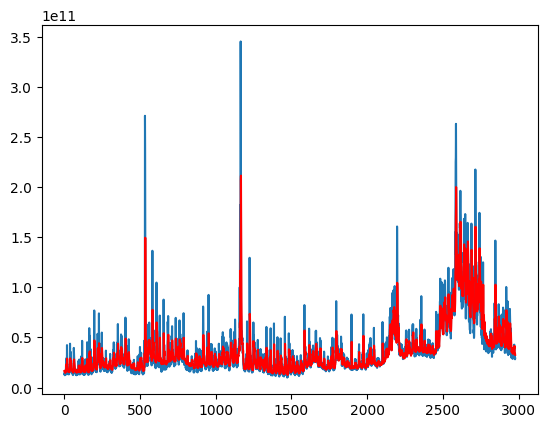

In [126]:
from math import sqrt
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = pd.read_csv('resources/gas_price_data_1year.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.index = series.index.to_period('D')
# Split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# Walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat}, expected={obs}')
# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')
# Plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()



